In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import util
import SSA
import importlib
import tensorflow as tf
from models import shallow_vgg
from skimage.transform import resize
from tensorflow.keras import losses, metrics, optimizers, callbacks

importlib.reload(shallow_vgg)

plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] ='Malgun Gothic'

In [2]:
def mean_error(y_true, y_pred):
    def _mean_error_score(y_true, y_pred):
        return np.mean(y_true - y_pred)
    score = tf.py_function(func=_mean_error_score, inp=[y_true, y_pred], Tout=tf.float32, name='mean_error')
    return score

In [3]:
data_path = "./data/2022_04_01_motion_imu/"
fn_list = os.listdir(data_path)
# user_list = ["인", "데이비드", "제이슨", "로제", "마이어", "찰스", "지나", "제임스", "미쉘"]
user_list = ["인", "데이비드", "제이슨", "로제", "마이어", "찰스", "제임스", "미쉘"]

leg_score = {"인": 31.46, "데이비드": 36.62, "제이슨": 17.51, "로제": 22.75, "마이어": 38.76, "찰스": 41.19, "지나": 20.04, "제임스": 31.66, "미쉘": 13.35}

body_info = {"인": [171, 70], "데이비드": [173, 67], "제이슨": [172, 47], "로제": [158, 53], "마이어": [174, 53], "찰스": [174, 64], "지나": [], "제임스": [171, 62], "미쉘": [159, 52]}


dic_list = {}

for fn in fn_list:
    user_name = fn.split("_")[0]
    if user_name not in user_list:
        continue

    if user_name not in dic_list:
        dic_list[user_name] = {}
        dic_list[user_name]["y"] = leg_score[user_name]
        dic_list[user_name]["body_info"] = body_info[user_name]

    df = pd.read_csv(f"{data_path}{fn}", sep=",", names=["ax", "ay", "az", "gx", "gy", "gz"])
    np_data = df.to_numpy()
    cpy_data = np_data.copy()

    ssa_list = []
    stft_list = []
    for i in range(6):
        target_data = np_data[:, i]
        stft = resize(util.stft(target_data, 64), (32, 128), mode='constant')
        stft_list.append(stft)
    np_ssa_list = np.array(ssa_list)
    np_stft_list = np.array(stft_list)

    if "stft" in dic_list[user_name]:
        dic_list[user_name]["stft"].append(np_stft_list)
    else:
        dic_list[user_name]["stft"] = [np_stft_list]


In [4]:
for user_name in dic_list:
    concat_arr = np.concatenate(dic_list[user_name]["stft"])
    # (time, freq, chan=부착위치)
    dic_list[user_name]["image"] = concat_arr.transpose((2, 1, 0))

In [5]:
user_list = ["인", "데이비드", "제이슨", "마이어", "찰스", "제임스", "로제", "미쉘"]

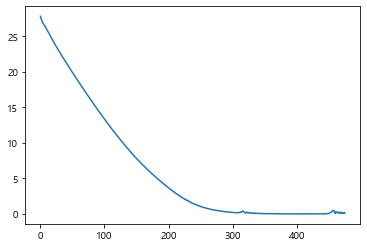

training error: 6.240430131553445
1/1 [==============================] - 0s 329ms/step - loss: 309.2636 - custom_output_loss: 309.2636 - custom_output_mean_squared_error: 309.2636 - custom_output_mean_absolute_error: 17.5859 - custom_output_mean_error: 17.5859


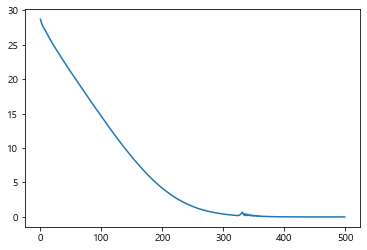

training error: 6.423328538821079
1/1 [==============================] - 0s 159ms/step - loss: 360.0645 - custom_output_loss: 360.0645 - custom_output_mean_squared_error: 360.0645 - custom_output_mean_absolute_error: 18.9754 - custom_output_mean_error: 18.9754


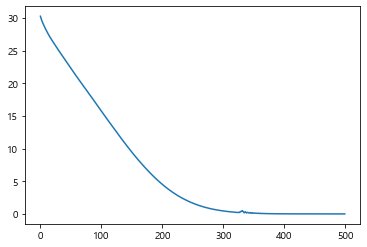

training error: 6.8668886829623
1/1 [==============================] - 0s 156ms/step - loss: 8.5726 - custom_output_loss: 8.5726 - custom_output_mean_squared_error: 8.5726 - custom_output_mean_absolute_error: 2.9279 - custom_output_mean_error: -2.9279


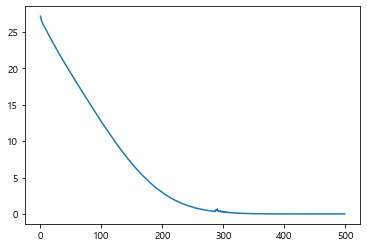

training error: 5.595732411757597
1/1 [==============================] - 0s 159ms/step - loss: 449.8866 - custom_output_loss: 449.8866 - custom_output_mean_squared_error: 449.8866 - custom_output_mean_absolute_error: 21.2105 - custom_output_mean_error: 21.2105


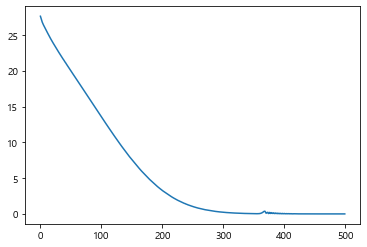

training error: 5.8931500358956646
1/1 [==============================] - 0s 157ms/step - loss: 77.9187 - custom_output_loss: 77.9187 - custom_output_mean_squared_error: 77.9187 - custom_output_mean_absolute_error: 8.8272 - custom_output_mean_error: 8.8272


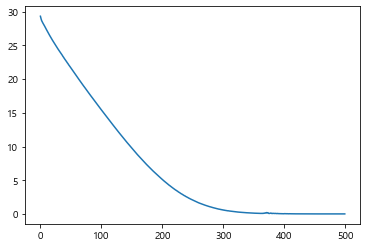

training error: 6.871839064050555
1/1 [==============================] - 0s 158ms/step - loss: 90.8287 - custom_output_loss: 90.8287 - custom_output_mean_squared_error: 90.8287 - custom_output_mean_absolute_error: 9.5304 - custom_output_mean_error: -9.5304


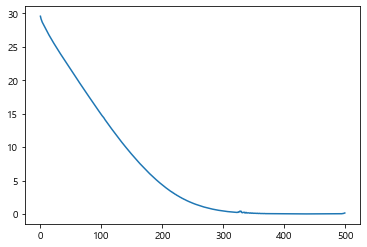

training error: 6.589524711069973
1/1 [==============================] - 0s 158ms/step - loss: 3.0185 - custom_output_loss: 3.0185 - custom_output_mean_squared_error: 3.0185 - custom_output_mean_absolute_error: 1.7374 - custom_output_mean_error: 1.7374


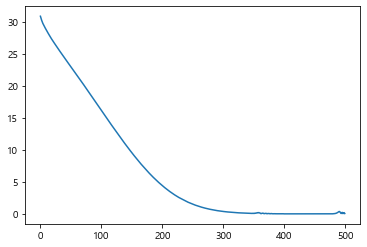

training error: 6.973855422605081
1/1 [==============================] - 0s 177ms/step - loss: 220.6528 - custom_output_loss: 220.6528 - custom_output_mean_squared_error: 220.6528 - custom_output_mean_absolute_error: 14.8544 - custom_output_mean_error: -14.8544


In [6]:
loss_history = []
for i in range(len(user_list)):
    test_X = np.expand_dims(dic_list[user_list[i]]["image"], axis=0)
    test_y = np.array([dic_list[user_list[i]]["y"]])
    train_X = []
    train_y = []
    for j in range(len(user_list)):
        if i == j:
            continue
        train_X.append(dic_list[user_list[j]]["image"])
        train_y.append(dic_list[user_list[j]]["y"])
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    # model = shallow_vgg.ShallowVGG(1, 1, 1)
    model = shallow_vgg.shallow_vgg(1, 1, 1)
    loss = losses.MeanSquaredError()
    optimizer = optimizers.Adam(learning_rate=1e-3)
    output_name = "custom_output"
    es = callbacks.EarlyStopping(
        monitor=f'{output_name}_mean_absolute_error',
        min_delta=0,
        patience=50,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
    # model.compile(optimizer=optimizer, loss={output_name: loss}, metrics={output_name: [metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), mean_error]})
    model.compile(optimizer=optimizer, loss={output_name: loss}, metrics= {output_name: [metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), mean_error]})
    history = model.fit(train_X, train_y, epochs=500, verbose=0, callbacks=[es])
    plt.plot(history.history[f"{output_name}_mean_absolute_error"])
    plt.show()
    print("training error:", np.mean(history.history[f"{output_name}_mean_error"]))
    eval_metric = model.evaluate(test_X, test_y)
    loss_history.append(eval_metric[3])

In [16]:
print(loss_history)
print("mean", np.mean(loss_history))
print("std", np.std(loss_history))

[-6.6996307373046875, 2.4242095947265625, -26.481782913208008, -13.715103149414062, -1.9869766235351562, -13.24135971069336, -15.099567413330078, -32.04571533203125]
mean -13.355740785598755
std 10.882042085941565


In [6]:
for key in dic_list:
    print(dic_list[key]["y"])

36.62
22.75
38.76
13.35
31.46
17.51
31.66
41.19


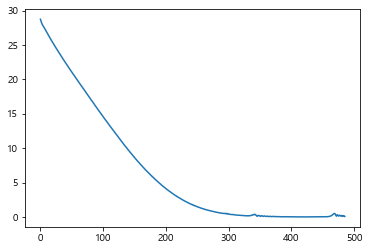

training error: 6.603346872572306
1/1 [==============================] - 0s 144ms/step - loss: 382.0452 - mean_squared_error: 382.0452 - mean_absolute_error: 19.5460 - mean_error: 19.5460


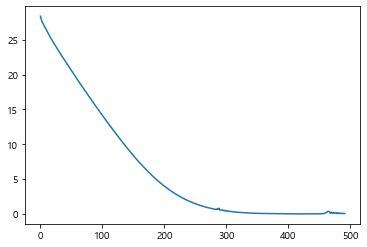

training error: 6.363477866775397
1/1 [==============================] - 0s 145ms/step - loss: 434.2396 - mean_squared_error: 434.2396 - mean_absolute_error: 20.8384 - mean_error: 20.8384


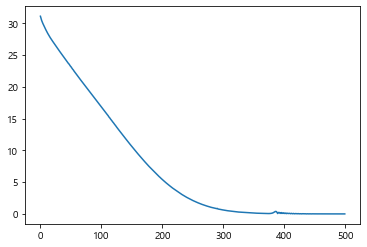

training error: 7.36852267951025
1/1 [==============================] - 0s 145ms/step - loss: 0.4260 - mean_squared_error: 0.4260 - mean_absolute_error: 0.6527 - mean_error: 0.6527


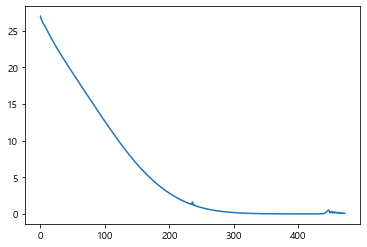

training error: 5.863376637242713
1/1 [==============================] - 0s 144ms/step - loss: 432.0583 - mean_squared_error: 432.0583 - mean_absolute_error: 20.7860 - mean_error: 20.7860


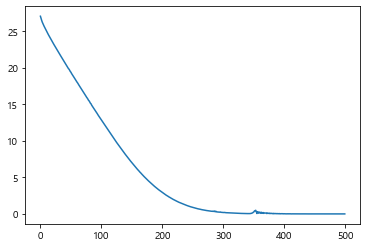

training error: 5.616147785645476
1/1 [==============================] - 0s 143ms/step - loss: 32.5845 - mean_squared_error: 32.5845 - mean_absolute_error: 5.7083 - mean_error: 5.7083


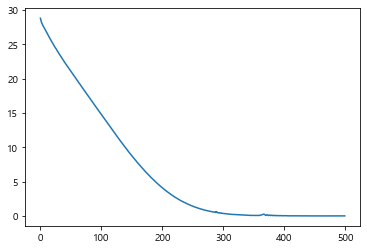

training error: 6.4199110898531
1/1 [==============================] - 0s 144ms/step - loss: 585.0514 - mean_squared_error: 585.0514 - mean_absolute_error: 24.1878 - mean_error: -24.1878


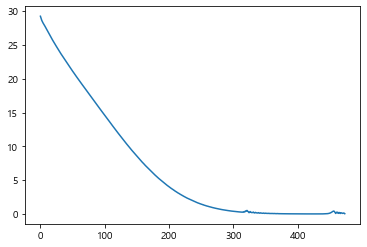

training error: 6.774801237452742
1/1 [==============================] - 0s 151ms/step - loss: 10.4109 - mean_squared_error: 10.4109 - mean_absolute_error: 3.2266 - mean_error: 3.2266


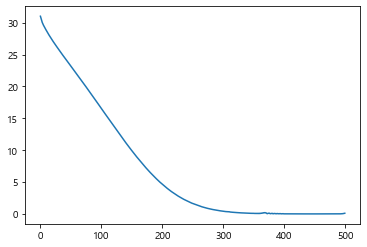

training error: 7.119691638794722
1/1 [==============================] - 0s 148ms/step - loss: 136.1118 - mean_squared_error: 136.1118 - mean_absolute_error: 11.6667 - mean_error: -11.6667


In [7]:
loss_history = []
for i in range(len(user_list)):
    test_X = np.expand_dims(dic_list[user_list[i]]["image"], axis=0)
    test_y = np.array([dic_list[user_list[i]]["y"]])
    train_X = []
    train_y = []
    for j in range(len(user_list)):
        if i == j:
            continue
        train_X.append(dic_list[user_list[j]]["image"])
        train_y.append(dic_list[user_list[j]]["y"])
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    model = shallow_vgg.ShallowVGG(1, 1, 1)
    loss = losses.MeanSquaredError()
    optimizer = optimizers.Adam(learning_rate=1e-3)
    es = callbacks.EarlyStopping(
        monitor=f'mean_absolute_error',
        min_delta=0,
        patience=50,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
    # model.compile(optimizer=optimizer, loss={output_name: loss}, metrics={output_name: [metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), mean_error]})
    model.compile(optimizer=optimizer, loss=loss, metrics= [metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), mean_error])
    history = model.fit(train_X, train_y, epochs=500, verbose=0, callbacks=[es])
    plt.plot(history.history[f"mean_absolute_error"])
    plt.show()
    print("training error:", np.mean(history.history[f"mean_error"]))
    eval_metric = model.evaluate(test_X, test_y)
    loss_history.append(eval_metric[3])